In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset
from scipy import sparse
import os
import copy
import random
from argoverse.data_loading.argoverse_forecasting_loader import ArgoverseForecastingLoader
from argoverse.map_representation.map_api import ArgoverseMap 
from skimage.transform import rotate
import matplotlib.pyplot as plt
from skimage.transform import rotate
from shapely.geometry.polygon import Polygon
from argoverse.visualization.visualize_sequences import viz_sequence

In [2]:
avm = ArgoverseMap()

In [3]:
data_path = os.path.join('../LaneGCN/', "dataset","preprocess", "val_crs_dist6_angle90.p")
data_argo = np.load(data_path, allow_pickle=True)

In [4]:
##set root_dir to the correct path to your dataset folder
root_dir = '../LaneGCN/dataset/val/data/'
afl = ArgoverseForecastingLoader(root_dir)
afl.seq_list = sorted(afl.seq_list)

32603


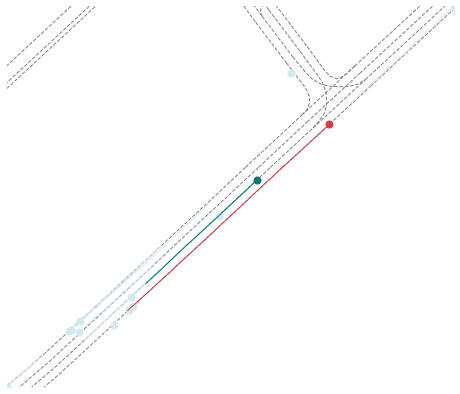

In [121]:
idx = np.random.randint(0, len(afl.seq_list), 1)[0]
print(idx)

seq_path = afl.seq_list[idx]
viz_sequence(afl.get(seq_path).seq_df, show=True)

In [6]:
city = data_argo[idx]['city']
orig = data_argo[idx]['orig']
final = data_argo[idx]['gt_preds'][0][-1]

## Check confidence

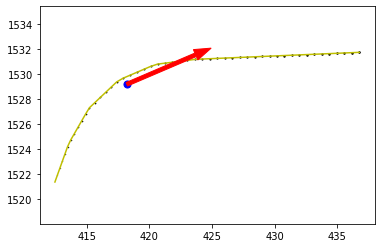

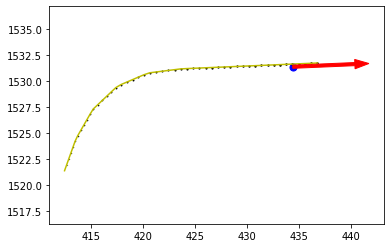

Confidence Final:  0.94838643338935 	 Confidence Orig:  0.8864237998985189 	
Confident
[0.54944739 0.23530472] [0.59717224 0.02541774]
Confidence flag:  1


In [7]:
flag_confidence = 1

lane_dir1 = avm.get_lane_direction(query_xy_city_coords=orig, city_name=city, visualize=True)
lane_dir2 = avm.get_lane_direction(query_xy_city_coords=final, city_name=city, visualize=True)

print("Confidence Final: ", lane_dir2[-1], "\t Confidence Orig: ", lane_dir1[-1], "\t" )

if lane_dir1[-1] > 0.8 and lane_dir2[-1] > 0.8:
    print('Confident')
    print(lane_dir1[0], lane_dir2[0])
else:
    print('Not confident')
    flag_confidence = -1
    
print("Confidence flag: ", flag_confidence)

## Check nearest centerline turning

In [8]:
lane_turn_flag = 1

lane_turn_orig = avm.get_lane_turn_direction(avm.get_nearest_centerline(orig, city)[0].id, city)
lane_turn_final = avm.get_lane_turn_direction(avm.get_nearest_centerline(final, city)[0].id, city)

if lane_turn_final!='NONE' or lane_turn_orig!='NONE':
    lane_turn_flag = -1

print(lane_turn_final, lane_turn_orig)
print("Turning flag: ", lane_turn_flag)

RIGHT RIGHT
Turning flag:  -1


## Check curvature of nearest centerlines

In [9]:
lane_curv_flag = 1

a = avm.get_nearest_centerline(orig, city)[0].centerline 
dir_lane = a[-1] - a[0]
lane_curv_orig = np.arctan2(dir_lane[-1], dir_lane[0])

b = avm.get_nearest_centerline(final, city)[0].centerline
dir_lane = b[-1] - b[0]
lane_curv_final = np.arctan2(dir_lane[-1], dir_lane[0])

if lane_curv_final * lane_curv_orig < 0:
    lane_curv_flag = -1
else:
    if abs(lane_curv_final - lane_curv_orig) > 0.1:
        lane_curv_flag = -1
        
print(lane_curv_final, lane_curv_orig, abs(lane_curv_final - lane_curv_orig))
print("Lane_curve_flag: ", lane_curv_flag)

0.4027717840130967 0.4027717840130967 0.0
Lane_curve_flag:  1


## Get anomaly function

In [10]:
def get_confidence_flag(city, orig, final):
    flag_confidence = 1
    lane_dir1 = avm.get_lane_direction(query_xy_city_coords=orig, city_name=city, visualize=False)
    lane_dir2 = avm.get_lane_direction(query_xy_city_coords=final, city_name=city, visualize=False)
    if lane_dir1[-1] < 0.8 or lane_dir2[-1] < 0.8:
        flag_confidence = -1
    return flag_confidence


def get_lane_turn_flag(city, orig, final):
    lane_turn_flag = 1

    lane_turn_orig = avm.get_lane_turn_direction(avm.get_nearest_centerline(orig, city)[0].id, city)
    lane_turn_final = avm.get_lane_turn_direction(avm.get_nearest_centerline(final, city)[0].id, city)

    if lane_turn_final!='NONE' or lane_turn_orig!='NONE':
        lane_turn_flag = -1
    return lane_turn_flag
    
    
def get_lane_curve_flag(city, orig, final):
    lane_curv_flag = 1
    
    a = avm.get_nearest_centerline(orig, city)[0].centerline 
    dir_lane = a[-1] - a[0]
    lane_curv_orig = np.arctan2(dir_lane[-1], dir_lane[0])
    
    b = avm.get_nearest_centerline(final, city)[0].centerline
    dir_lane = b[-1] - b[0]
    lane_curv_final = np.arctan2(dir_lane[-1], dir_lane[0])
    
    if lane_curv_final * lane_curv_orig < 0:
        lane_curv_flag = -1
    else:
        if abs(lane_curv_final - lane_curv_orig) > 0.1:
            lane_curv_flag = -1
    return lane_curv_flag

In [40]:
import time
t = time.process_time()

anomaly_ids = []

for idx in range(len(afl.seq_list)):
    if idx % 1000 == 0:
        print(idx)
    city = data_argo[idx]['city']
    orig = data_argo[idx]['orig']
    final = data_argo[idx]['gt_preds'][0][-1]
    
    sc1 = get_confidence_flag(city, orig, final)
    sc2 = get_lane_turn_flag(city, orig, final)
    sc3 = get_lane_curve_flag(city, orig, final)
    
    if sc1 == -1 or sc2 == -1 or sc3 == -1:
        anomaly_ids.append(idx)

elapsed_time = time.process_time() - t
print(elapsed_time)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
1192.928416809


In [41]:
print(len(anomaly_ids))

15219


## Visualize some cases

2663


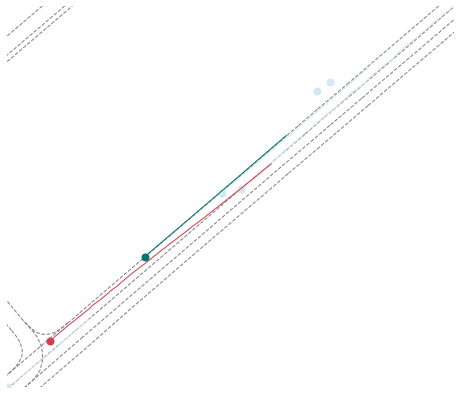

In [44]:
idx = np.random.randint(0, len(anomaly_ids), 1)[0]
show_idx = anomaly_ids[idx]
print(show_idx)
seq_path = afl.seq_list[show_idx]
viz_sequence(afl.get(seq_path).seq_df, show=True)

7631


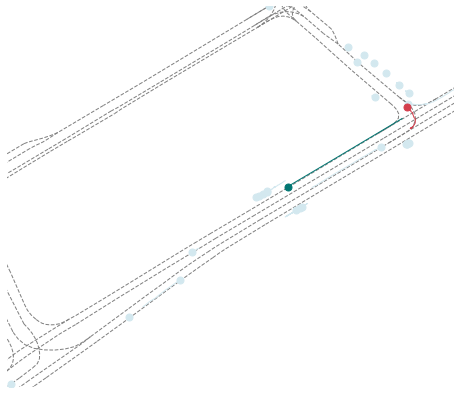

In [57]:
idx = np.random.randint(0, len(anomaly_ids), 1)[0]
show_idx = anomaly_ids[idx]
print(show_idx)
seq_path = afl.seq_list[show_idx]
viz_sequence(afl.get(seq_path).seq_df, show=True)

16026


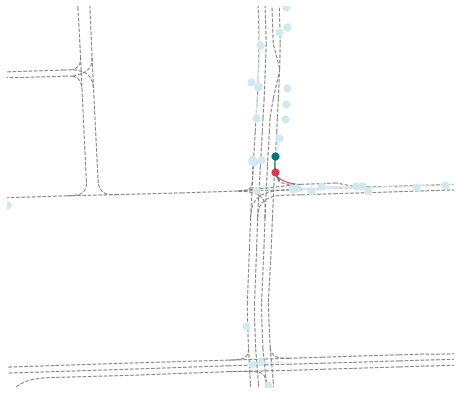

In [48]:
idx = np.random.randint(0, len(anomaly_ids), 1)[0]
show_idx = anomaly_ids[idx]
print(show_idx)
seq_path = afl.seq_list[show_idx]
viz_sequence(afl.get(seq_path).seq_df, show=True)

30343


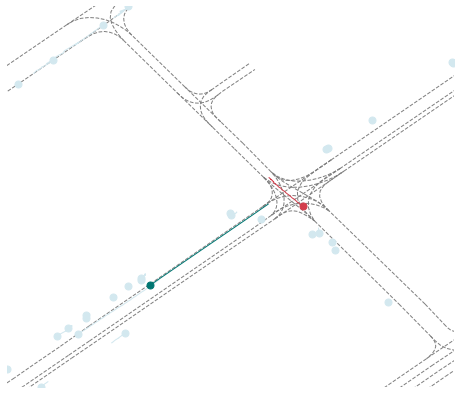

In [103]:
idx = np.random.randint(0, len(anomaly_ids), 1)[0]
show_idx = anomaly_ids[idx]
print(show_idx)
seq_path = afl.seq_list[show_idx]
viz_sequence(afl.get(seq_path).seq_df, show=True)

14013


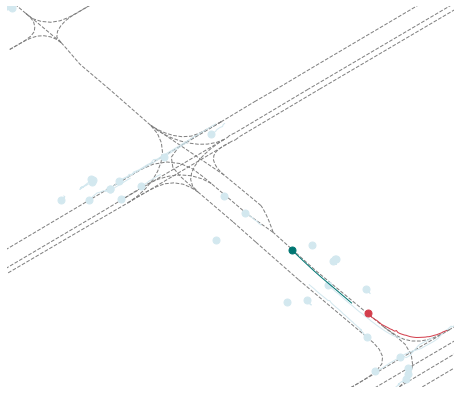

In [56]:
idx = np.random.randint(0, len(anomaly_ids), 1)[0]
show_idx = anomaly_ids[idx]
print(show_idx)
seq_path = afl.seq_list[show_idx]
viz_sequence(afl.get(seq_path).seq_df, show=True)

31840


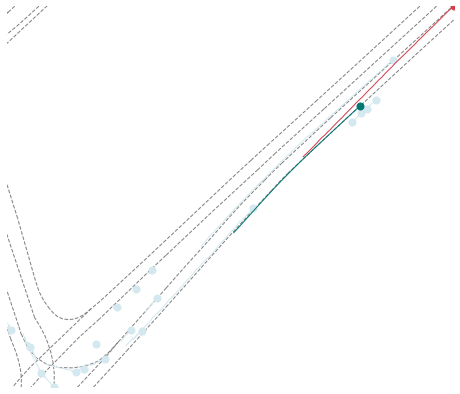

In [71]:
idx = np.random.randint(0, len(anomaly_ids), 1)[0]
show_idx = anomaly_ids[idx]
print(show_idx)
seq_path = afl.seq_list[show_idx]
viz_sequence(afl.get(seq_path).seq_df, show=True)

17886


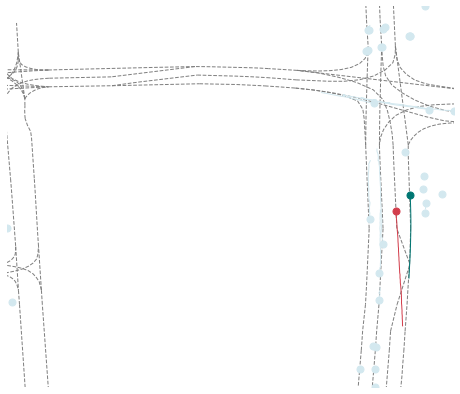

In [68]:
idx = np.random.randint(0, len(anomaly_ids), 1)[0]
show_idx = anomaly_ids[idx]
print(show_idx)
seq_path = afl.seq_list[show_idx]
viz_sequence(afl.get(seq_path).seq_df, show=True)

32533


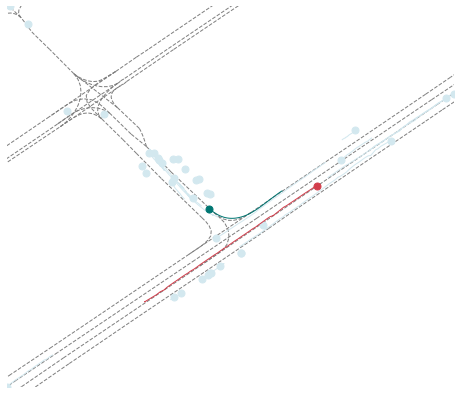

In [88]:
idx = np.random.randint(0, len(anomaly_ids), 1)[0]
show_idx = anomaly_ids[idx]
print(show_idx)
seq_path = afl.seq_list[show_idx]
viz_sequence(afl.get(seq_path).seq_df, show=True)

27795


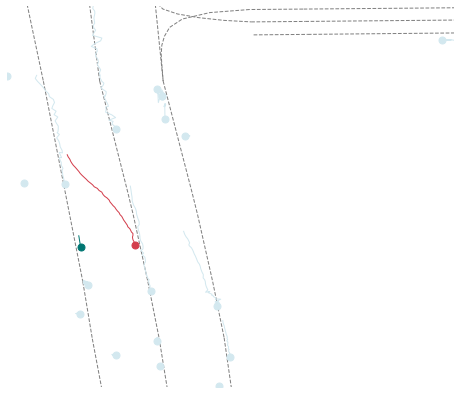

In [107]:
idx = np.random.randint(0, len(anomaly_ids), 1)[0]
show_idx = anomaly_ids[idx]
print(show_idx)
seq_path = afl.seq_list[show_idx]
viz_sequence(afl.get(seq_path).seq_df, show=True)

21158


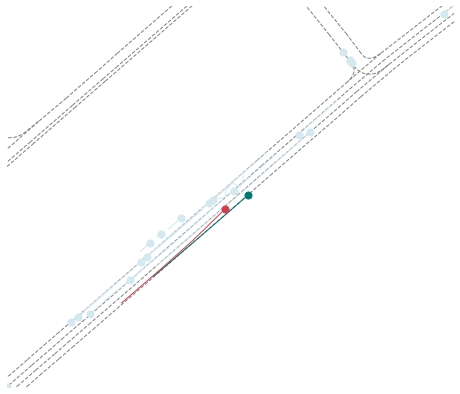

In [114]:
idx = np.random.randint(0, len(anomaly_ids), 1)[0]
show_idx = anomaly_ids[idx]
print(show_idx)
seq_path = afl.seq_list[show_idx]
viz_sequence(afl.get(seq_path).seq_df, show=True)